# Classifying ALL with XGBoost using Optuna

In this notebook I was using Optuna to tune XGBoost's hyperparameters. I was experimenting with different parameter spaces for Optuna optimization. f1_score was used as the metrics to find the best trial.

Parameter spaces #3 and #4 resulted in two best performing models in this notebook.



## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 13.5 MB/s eta 0:00:00


## Dependencies

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import joblib

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.utils.fixes import loguniform

from scipy.stats import uniform, truncnorm, randint, loguniform

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score

# Function for creating model pipelines - imblearn
## from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-sampling using SMOTE
## from imblearn.over_sampling import SMOTE

# Import XGBoost
from xgboost import XGBClassifier

# Import Optuna
import optuna
from optuna.samplers import TPESampler
from optuna.integration import XGBoostPruningCallback


import warnings
warnings.filterwarnings('ignore')

random_state = 10

In [4]:
# Import the script from different folder
import sys  
sys.path.append('/content/drive/MyDrive/Omdena/Team1/scripts')

import metrics_utilities as mu

## Batch_4 Train Dataset

In [5]:
df_train = pd.read_pickle('/content/drive/MyDrive/Omdena/Team1/batch_4/train_data.pickle')
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4599,4600,4601,4602,4603,4604,4605,4606,4607,label
0,0.185833,0.0,0.00000,0.000000,0.0,0.0,0.0,0.231458,0.0,0.0,...,0.545079,0.170755,0.0,0.096298,0.174819,0.0,0.0,0.361853,0.0,0
1,0.123157,0.0,0.56544,0.350086,0.0,0.0,0.0,0.228849,0.0,0.0,...,0.663390,0.115025,0.0,0.099379,0.516193,0.0,0.0,0.239392,0.0,1
2,0.197977,0.0,0.00000,0.000000,0.0,0.0,0.0,0.155163,0.0,0.0,...,0.663023,0.021846,0.0,0.000000,0.173690,0.0,0.0,0.270634,0.0,1
3,0.580151,0.0,0.00000,0.000000,0.0,0.0,0.0,0.298566,0.0,0.0,...,0.470815,0.000000,0.0,0.000000,0.118325,0.0,0.0,0.000000,0.0,0
4,0.066450,0.0,0.00000,0.000000,0.0,0.0,0.0,0.145156,0.0,0.0,...,0.645798,0.015262,0.0,0.027536,0.275665,0.0,0.0,0.000000,0.0,0


#### Separate features and labels

In [6]:
X_train = df_train.iloc[:, : -1]
y_train = df_train['label']
print(X_train.shape, y_train.shape)

(11917, 4608) (11917,)


## Batch_4 Test Dataset

In [7]:
df_test = pd.read_pickle('/content/drive/MyDrive/Omdena/Team1/batch_4/test_data.pickle')
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,4599,4600,4601,4602,4603,4604,4605,4606,4607,label
0,0.141500,0.0,0.000000,0.000000,0.0,0.0,0.0,0.151137,0.0,0.0,...,0.885778,0.066009,0.0,0.169458,0.570154,0.0,0.0,0.090579,0.0,0
1,0.047403,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.649062,0.260996,0.0,0.049776,0.494771,0.0,0.0,0.480568,0.0,0
2,0.000000,0.0,0.000000,0.023559,0.0,0.0,0.0,0.060329,0.0,0.0,...,0.725523,0.166289,0.0,0.131945,0.299330,0.0,0.0,0.000000,0.0,0
3,0.002286,0.0,0.655825,0.259398,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.626934,0.244303,0.0,0.100791,0.448022,0.0,0.0,0.295682,0.0,0
4,0.279953,0.0,0.000000,0.000000,0.0,0.0,0.0,0.168589,0.0,0.0,...,0.489483,0.166786,0.0,0.000000,0.212874,0.0,0.0,0.000000,0.0,0


#### Separate features and labels

In [8]:
X_test = df_test.iloc[:, :-1]
y_test = df_test['label']
print(X_test.shape, y_test.shape)

(1794, 4608) (1794,)


#### Names of Classes

In [9]:
target_names = ['hem', 'all']

# Fit the Base Model

In [ ]:
clf_xgb = XGBClassifier(tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)

In [ ]:
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [ ]:
clf_xgb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'auc',
 'feature_types': None,
 'gamma': None,
 'gpu_id': 0,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 10,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'gpu_hist',
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
# Save the model
joblib.dump(clf_xgb, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_base.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_base.save']

In [ ]:
y_pred = clf_xgb.predict(X_test)

In [ ]:
y_pred

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
accuracy_score(y_test, y_pred)

0.8494983277591973

In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {clf_xgb.score(X_train, y_train)}")
print(f"Testing Data Score: {clf_xgb.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8494983277591973


In [ ]:
confusion_matrix(y_test, y_pred)

array([[ 237,  102],
       [ 168, 1287]])

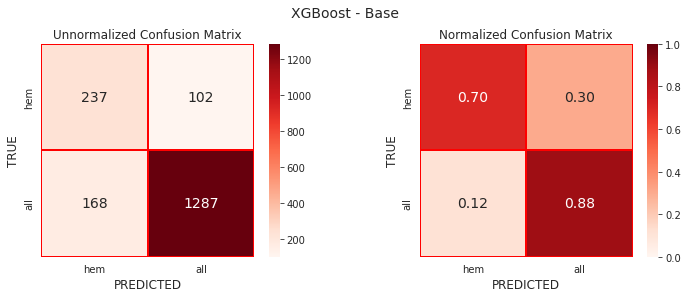

In [ ]:
# Plot confusion matrices
mu.plot_cm_unnorm_and_norm('XGBoost - Base', y_test, y_pred, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.59      0.70      0.64       339
         all       0.93      0.88      0.91      1455

    accuracy                           0.85      1794
   macro avg       0.76      0.79      0.77      1794
weighted avg       0.86      0.85      0.85      1794



# Optuna - GPU #1

## Optuna Objective Function

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
    }

    # Fit the model
    model = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate predictions
    ###  accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return f1

## Optuna Study

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2023-04-14 19:21:07,175] A new study created in memory with name: no-name-561e30f1-fb23-4e46-ab33-30beb7a80fd3


## Optimize the Objective Function

In [ ]:
study.optimize(objective, n_trials=100)

[I 2023-04-14 19:21:53,392] Trial 0 finished with value: 0.7987965400526514 and parameters: {'max_depth': 8, 'learning_rate': 0.3910353165477015, 'n_estimators': 446, 'min_child_weight': 4, 'gamma': 2.814343484432268e-08, 'subsample': 0.0505627187432225, 'colsample_bytree': 0.07185099266502325, 'reg_alpha': 0.05221166768145267, 'reg_lambda': 1.7883031999517404e-05}. Best is trial 0 with value: 0.7987965400526514.
[I 2023-04-14 19:22:03,021] Trial 1 finished with value: 0.8554954954954956 and parameters: {'max_depth': 1, 'learning_rate': 0.13807527025872596, 'n_estimators': 279, 'min_child_weight': 2, 'gamma': 0.00017146115700361416, 'subsample': 0.03471749006030695, 'colsample_bytree': 0.18384856462057098, 'reg_alpha': 1.2624402674452547e-05, 'reg_lambda': 0.0008070699542521926}. Best is trial 1 with value: 0.8554954954954956.
[I 2023-04-14 19:22:10,938] Trial 2 finished with value: 0.8875 and parameters: {'max_depth': 9, 'learning_rate': 0.018548812041270124, 'n_estimators': 68, 'min_

## Best Parameters

In [ ]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.9183176920403199
  Params: 
    max_depth: 8
    learning_rate: 0.04497541857028905
    n_estimators: 487
    min_child_weight: 3
    gamma: 0.04600466760963211
    subsample: 0.5855105248431615
    colsample_bytree: 0.9912443533980352
    reg_alpha: 3.377629861470216e-05
    reg_lambda: 0.268518280951096


## Re-fit the model

In [ ]:
params = trial.params

clf_xgb_opt = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
clf_xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9912443533980352, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.04600466760963211, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.04497541857028905, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=487, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [ ]:
# Save the model
joblib.dump(clf_xgb_opt, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_1.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_1.save']

In [ ]:
y_pred_opt = clf_xgb_opt.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_opt)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 86.90


In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {clf_xgb_opt.score(X_train, y_train)}")
print(f"Testing Data Score: {clf_xgb_opt.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8690078037904125


In [ ]:
cm = confusion_matrix(y_test, y_pred_opt)
print(cm)

[[ 238  101]
 [ 134 1321]]


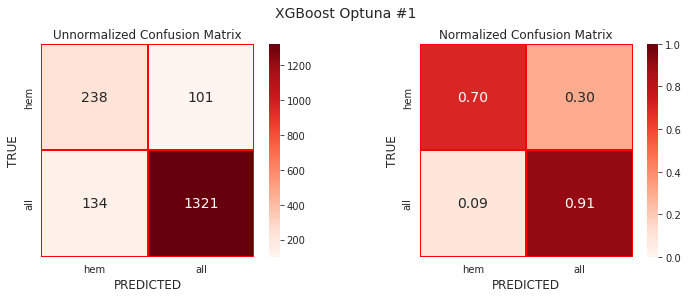

In [ ]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('XGBoost Optuna #1', y_test, y_pred_opt, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred_opt, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.64      0.70      0.67       339
         all       0.93      0.91      0.92      1455

    accuracy                           0.87      1794
   macro avg       0.78      0.80      0.79      1794
weighted avg       0.87      0.87      0.87      1794



# Optuna GPU #2

## Optuna Objective Function

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 12), # changed
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 600), # changed
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    # Fit the model
    model = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate predictions
    ###  accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return f1

## Optuna Study

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2023-04-14 21:30:29,388] A new study created in memory with name: no-name-62a0c973-4787-437d-89d3-f4a3b1ea6e69


## Optimize the Objective Function

In [ ]:
study.optimize(objective, n_trials=100)

[I 2023-04-14 21:30:50,697] Trial 0 finished with value: 0.8187869822485206 and parameters: {'max_depth': 5, 'learning_rate': 0.4713706437564653, 'n_estimators': 439, 'min_child_weight': 3, 'gamma': 0.24995469105361307, 'subsample': 0.060421109791557535, 'colsample_bytree': 0.045746842672934517, 'reg_alpha': 2.029575810602989e-08, 'reg_lambda': 0.05303904178895127}. Best is trial 0 with value: 0.8187869822485206.
[I 2023-04-14 21:31:11,064] Trial 1 finished with value: 0.8705629257798494 and parameters: {'max_depth': 6, 'learning_rate': 0.05132574280062056, 'n_estimators': 560, 'min_child_weight': 6, 'gamma': 0.00018933825336895719, 'subsample': 0.032676166449997046, 'colsample_bytree': 0.30872127660651727, 'reg_alpha': 0.05206534895612165, 'reg_lambda': 0.11921194013851594}. Best is trial 1 with value: 0.8705629257798494.
[I 2023-04-14 21:31:28,100] Trial 2 finished with value: 0.8540145985401459 and parameters: {'max_depth': 10, 'learning_rate': 0.29987677915338307, 'n_estimators': 2

## Best Parameters

In [ ]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.9182259182259181
  Params: 
    max_depth: 12
    learning_rate: 0.1067285073865253
    n_estimators: 286
    min_child_weight: 2
    gamma: 0.00020223465634850888
    subsample: 0.9935197044410982
    colsample_bytree: 0.12499860335425486
    reg_alpha: 0.0033367758797314107
    reg_lambda: 0.0032444067156075468


## Re-fit the model

In [ ]:
params = trial.params

clf_xgb_opt = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
clf_xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.12499860335425486, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.00020223465634850888, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1067285073865253, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=286, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [ ]:
# Save the model
joblib.dump(clf_xgb_opt, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_2.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_2.save']

In [ ]:
y_pred_opt = clf_xgb_opt.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_opt)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 86.85


In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {clf_xgb_opt.score(X_train, y_train)}")
print(f"Testing Data Score: {clf_xgb_opt.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8509142053445851


In [ ]:
cm = confusion_matrix(y_test, y_pred_opt)
print(cm)

[[ 233  106]
 [ 130 1325]]


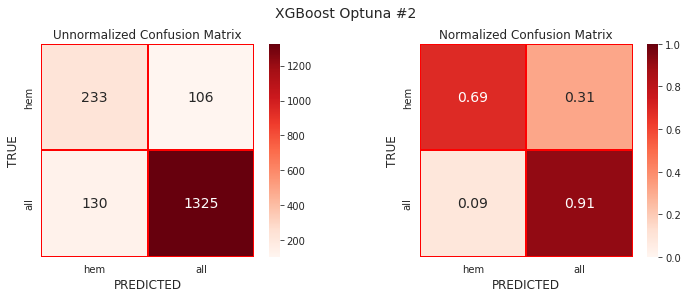

In [ ]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('XGBoost Optuna #2', y_test, y_pred_opt, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred_opt, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.64      0.69      0.66       339
         all       0.93      0.91      0.92      1455

    accuracy                           0.87      1794
   macro avg       0.78      0.80      0.79      1794
weighted avg       0.87      0.87      0.87      1794



# Optuna GPU #3

## Optuna Objective Function

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 6, 14), # changed
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 150, 500), # changed
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6), # changed
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    # Fit the model
    model = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate predictions
    ###  accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return f1

## Optuna Study

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2023-04-14 22:35:49,824] A new study created in memory with name: no-name-9fd34385-24e8-4706-ad4d-87a2023af461


## Optimize the Objective Function

In [ ]:
study.optimize(objective, n_trials=100)

[I 2023-04-14 22:36:11,775] Trial 0 finished with value: 0.8227054920751935 and parameters: {'max_depth': 6, 'learning_rate': 0.11177163767800849, 'n_estimators': 278, 'min_child_weight': 1, 'gamma': 1.4965183900481227e-08, 'subsample': 0.030210153237243815, 'colsample_bytree': 0.792380284002305, 'reg_alpha': 0.006129675000758282, 'reg_lambda': 0.012554454724956003}. Best is trial 0 with value: 0.8227054920751935.
[I 2023-04-14 22:36:21,843] Trial 1 finished with value: 0.8207617625093353 and parameters: {'max_depth': 6, 'learning_rate': 0.5950565786453383, 'n_estimators': 218, 'min_child_weight': 6, 'gamma': 1.0994422377014965e-08, 'subsample': 0.08280565385374866, 'colsample_bytree': 0.9803667619566732, 'reg_alpha': 0.004396092901569135, 'reg_lambda': 0.0002996682003425331}. Best is trial 0 with value: 0.8227054920751935.
[I 2023-04-14 22:36:37,996] Trial 2 finished with value: 0.8357221609702316 and parameters: {'max_depth': 12, 'learning_rate': 0.06347228463744889, 'n_estimators': 

## Best Parameters

In [ ]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.9210526315789473
  Params: 
    max_depth: 13
    learning_rate: 0.06014806564595053
    n_estimators: 463
    min_child_weight: 1
    gamma: 0.03586490965277041
    subsample: 0.7407986525747484
    colsample_bytree: 0.4372894834245913
    reg_alpha: 3.65055382908242e-08
    reg_lambda: 7.608239967711364e-08


## Re-fit the model

In [ ]:
params = trial.params

clf_xgb_opt = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
clf_xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4372894834245913, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.03586490965277041, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.06014806564595053, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=463, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [ ]:
# Save the model
joblib.dump(clf_xgb_opt, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_3.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_3.save']

In [ ]:
y_pred_opt = clf_xgb_opt.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_opt)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 87.29


In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {clf_xgb_opt.score(X_train, y_train)}")
print(f"Testing Data Score: {clf_xgb_opt.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8729096989966555


In [ ]:
cm = confusion_matrix(y_test, y_pred_opt)
print(cm)

[[ 236  103]
 [ 125 1330]]


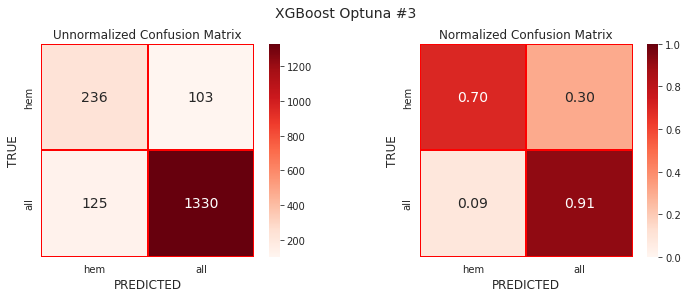

In [ ]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('XGBoost Optuna #3', y_test, y_pred_opt, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred_opt, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.65      0.70      0.67       339
         all       0.93      0.91      0.92      1455

    accuracy                           0.87      1794
   macro avg       0.79      0.81      0.80      1794
weighted avg       0.88      0.87      0.87      1794



# Optuna GPU #4

## Optuna Objective Function

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 10, 18), # changed
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators',200, 650), # changed
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6), 
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    # Fit the model
    model = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate predictions
    ###  accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return f1

## Optuna Study

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2023-04-15 00:14:35,315] A new study created in memory with name: no-name-4db63cb1-323a-4eac-bdb7-abc980c5300b


## Optimize the Objective Function

In [ ]:
study.optimize(objective, n_trials=100)

[I 2023-04-15 00:15:15,444] Trial 0 finished with value: 0.906927921623513 and parameters: {'max_depth': 18, 'learning_rate': 0.0963652822661919, 'n_estimators': 437, 'min_child_weight': 1, 'gamma': 0.5577404507143334, 'subsample': 0.5207518470971227, 'colsample_bytree': 0.2680541780713506, 'reg_alpha': 1.842127428724471e-08, 'reg_lambda': 0.01444535978504234}. Best is trial 0 with value: 0.906927921623513.
[I 2023-04-15 00:15:46,552] Trial 1 finished with value: 0.8651564185544768 and parameters: {'max_depth': 13, 'learning_rate': 0.0530140405542391, 'n_estimators': 531, 'min_child_weight': 3, 'gamma': 1.4073175816178684e-08, 'subsample': 0.05091929028546871, 'colsample_bytree': 0.5688913897498983, 'reg_alpha': 0.0037947909191049923, 'reg_lambda': 4.475191055243736e-08}. Best is trial 0 with value: 0.906927921623513.
[I 2023-04-15 00:16:01,352] Trial 2 finished with value: 0.8721965112139551 and parameters: {'max_depth': 13, 'learning_rate': 0.031386634660407545, 'n_estimators': 411, 

## Best Parameters

In [ ]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.917941585535466
  Params: 
    max_depth: 16
    learning_rate: 0.07979824718764753
    n_estimators: 609
    min_child_weight: 6
    gamma: 8.781937455551666e-05
    subsample: 0.7473404422391613
    colsample_bytree: 0.09379487482256367
    reg_alpha: 7.105174671237298e-08
    reg_lambda: 0.0011354245390916625


## Re-fit the model

In [ ]:
params = trial.params

clf_xgb_opt = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
clf_xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.09379487482256367, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=8.781937455551666e-05, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.07979824718764753, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=609, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [ ]:
# Save the model
joblib.dump(clf_xgb_opt, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_4.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_4.save']

In [ ]:
y_pred_opt = clf_xgb_opt.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_opt)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 86.85


In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {clf_xgb_opt.score(X_train, y_train)}")
print(f"Testing Data Score: {clf_xgb_opt.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8684503901895206


In [ ]:
cm = confusion_matrix(y_test, y_pred_opt)
print(cm)

[[ 238  101]
 [ 135 1320]]


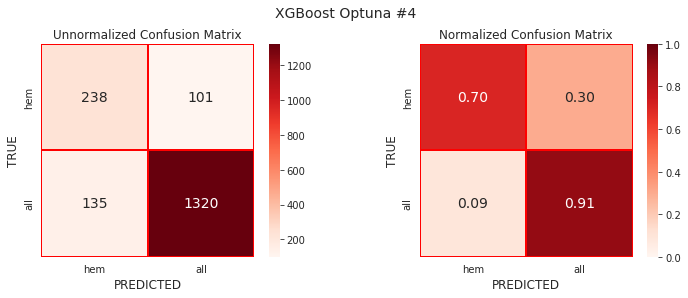

In [ ]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('XGBoost Optuna #4', y_test, y_pred_opt, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred_opt, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.64      0.70      0.67       339
         all       0.93      0.91      0.92      1455

    accuracy                           0.87      1794
   macro avg       0.78      0.80      0.79      1794
weighted avg       0.87      0.87      0.87      1794



# Optuna GPU #5

## Optuna Objective Function

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 10, 20), # changed
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators',200, 700), # changed
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 8), # changed
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    # Fit the model
    model = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate predictions
    ###  accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return f1

## Optuna Study

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2023-04-15 01:49:09,089] A new study created in memory with name: no-name-e1cd0407-1efc-4509-a037-3d73f656190d


## Optimize the Objective Function

In [ ]:
study.optimize(objective, n_trials=100)

[I 2023-04-15 01:49:38,025] Trial 0 finished with value: 0.897209466619569 and parameters: {'max_depth': 14, 'learning_rate': 0.24369164319942557, 'n_estimators': 419, 'min_child_weight': 8, 'gamma': 1.2842635213961471e-07, 'subsample': 0.5566396080875273, 'colsample_bytree': 0.04698507901556557, 'reg_alpha': 1.7800174353130742e-08, 'reg_lambda': 0.002394193289708109}. Best is trial 0 with value: 0.897209466619569.
[I 2023-04-15 01:50:45,190] Trial 1 finished with value: 0.8979305506839707 and parameters: {'max_depth': 14, 'learning_rate': 0.04928762290100827, 'n_estimators': 387, 'min_child_weight': 1, 'gamma': 6.134196100012216e-06, 'subsample': 0.10694212032652084, 'colsample_bytree': 0.7365273594945804, 'reg_alpha': 0.0009713063118148452, 'reg_lambda': 3.537609122701986e-08}. Best is trial 1 with value: 0.8979305506839707.
[I 2023-04-15 01:51:51,083] Trial 2 finished with value: 0.9052264808362369 and parameters: {'max_depth': 19, 'learning_rate': 0.04386174637329769, 'n_estimators

## Best Parameters

In [ ]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.921007243877199
  Params: 
    max_depth: 15
    learning_rate: 0.0339515717933877
    n_estimators: 690
    min_child_weight: 5
    gamma: 1.3852144252844677e-07
    subsample: 0.7614347110849297
    colsample_bytree: 0.08200542120614482
    reg_alpha: 1.7402309072515836e-08
    reg_lambda: 0.13914441551714987


## Re-fit the model

In [ ]:
params = trial.params

clf_xgb_opt = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
clf_xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.08200542120614482, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1.3852144252844677e-07, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0339515717933877, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=690, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [ ]:
# Save the model
joblib.dump(clf_xgb_opt, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_5.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_5.save']

In [ ]:
y_pred_opt = clf_xgb_opt.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_opt)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 87.24


In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {clf_xgb_opt.score(X_train, y_train)}")
print(f"Testing Data Score: {clf_xgb_opt.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8723522853957637


In [ ]:
cm = confusion_matrix(y_test, y_pred_opt)
print(cm)

[[ 230  109]
 [ 120 1335]]


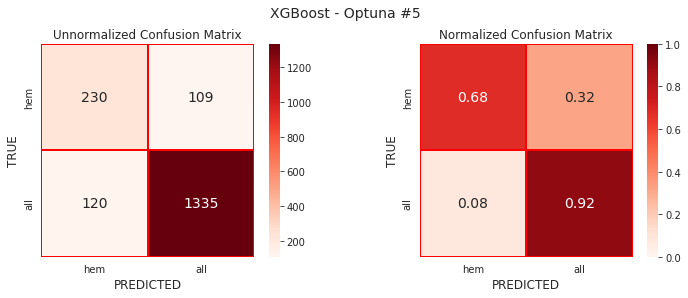

In [ ]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('XGBoost - Optuna #5', y_test, y_pred_opt, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred_opt, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.66      0.68      0.67       339
         all       0.92      0.92      0.92      1455

    accuracy                           0.87      1794
   macro avg       0.79      0.80      0.79      1794
weighted avg       0.87      0.87      0.87      1794



# Optuna GPU & CV3-mean #6

## Optuna Objective Function

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 10, 20), # changed
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 200, 700), # changed
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 8), # changed
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    # Fit the model
    model = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
    # model.fit(X_train, y_train)

    # # Make predictions
    # y_pred = model.predict(X_test)

    # # Evaluate predictions
    # ###  accuracy = accuracy_score(y_test, y_pred)
    # f1 = f1_score(y_test, y_pred)
    # return f1

    return cross_val_score(model, X_train, y_train, scoring='f1', cv=3).mean()

## Optuna Study

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2023-04-15 04:05:53,095] A new study created in memory with name: no-name-0ddd9f3b-c823-4ecf-acdf-aea3080c58c2


## Optimize the Objective Function

In [ ]:
study.optimize(objective, n_trials=100)

[I 2023-04-15 04:06:43,748] Trial 0 finished with value: 0.6914026079735235 and parameters: {'max_depth': 18, 'learning_rate': 0.768425826888075, 'n_estimators': 608, 'min_child_weight': 1, 'gamma': 2.1454141904279137e-06, 'subsample': 0.020662190129163382, 'colsample_bytree': 0.08029649023108834, 'reg_alpha': 0.07120921448100824, 'reg_lambda': 0.01693352886747687}. Best is trial 0 with value: 0.6914026079735235.
[I 2023-04-15 04:07:54,301] Trial 1 finished with value: 0.8460779826500757 and parameters: {'max_depth': 10, 'learning_rate': 0.43846168250712386, 'n_estimators': 510, 'min_child_weight': 7, 'gamma': 0.008767534829486306, 'subsample': 0.6538569881413887, 'colsample_bytree': 0.4535199545635296, 'reg_alpha': 1.0854447879078911e-08, 'reg_lambda': 1.9523021251709682e-07}. Best is trial 1 with value: 0.8460779826500757.
[I 2023-04-15 04:08:56,902] Trial 2 finished with value: 0.834632704723048 and parameters: {'max_depth': 13, 'learning_rate': 0.12204327400306982, 'n_estimators': 

## Best Parameters

In [ ]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.867694092296729
  Params: 
    max_depth: 16
    learning_rate: 0.061128479957932094
    n_estimators: 628
    min_child_weight: 6
    gamma: 0.014359590176481496
    subsample: 0.7428786389315983
    colsample_bytree: 0.2739133504823023
    reg_alpha: 0.00020565504150405823
    reg_lambda: 0.00022254045942358532


## Re-fit the model

In [ ]:
params = trial.params

clf_xgb_opt = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
clf_xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.2739133504823023, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.014359590176481496, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.061128479957932094, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=628, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [ ]:
# Save the model
joblib.dump(clf_xgb_opt, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_6.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_6.save']

In [ ]:
y_pred_opt = clf_xgb_opt.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_opt)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 86.45


In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {clf_xgb_opt.score(X_train, y_train)}")
print(f"Testing Data Score: {clf_xgb_opt.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8645484949832776


In [ ]:
cm = confusion_matrix(y_test, y_pred_opt)
print(cm)

[[ 237  102]
 [ 141 1314]]


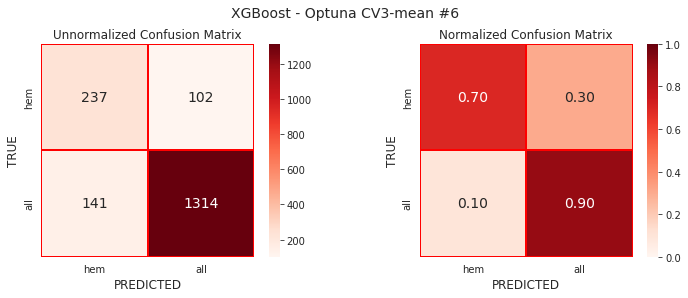

In [ ]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('XGBoost - Optuna CV3-mean #6', y_test, y_pred_opt, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred_opt, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.63      0.70      0.66       339
         all       0.93      0.90      0.92      1455

    accuracy                           0.86      1794
   macro avg       0.78      0.80      0.79      1794
weighted avg       0.87      0.86      0.87      1794



# Optuna GPU & CV5-mean #7

## Optuna Objective Function

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 10, 20), # changed
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 200, 700), # changed
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 8), # changed
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    # Fit the model
    model = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
    # model.fit(X_train, y_train)

    # # Make predictions
    # y_pred = model.predict(X_test)

    # # Evaluate predictions
    # ###  accuracy = accuracy_score(y_test, y_pred)
    # f1 = f1_score(y_test, y_pred)
    # return f1

    return cross_val_score(model, X_train, y_train, scoring='f1', cv=5).mean()

## Optuna Study

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2023-04-15 12:46:29,256] A new study created in memory with name: no-name-bb040541-0aa6-4fda-8078-65b4c9676629


## Optimize the Objective Function

In [ ]:
study.optimize(objective, n_trials=100)

[I 2023-04-15 12:49:51,410] Trial 0 finished with value: 0.8695089820020885 and parameters: {'max_depth': 12, 'learning_rate': 0.04920287215432348, 'n_estimators': 488, 'min_child_weight': 8, 'gamma': 4.092048126493102e-08, 'subsample': 0.5771454644557982, 'colsample_bytree': 0.28969236649093244, 'reg_alpha': 0.0014078036392999379, 'reg_lambda': 0.01874869861791909}. Best is trial 0 with value: 0.8695089820020885.
[I 2023-04-15 12:51:09,175] Trial 1 finished with value: 0.7583271744706204 and parameters: {'max_depth': 19, 'learning_rate': 0.3432867950236547, 'n_estimators': 452, 'min_child_weight': 6, 'gamma': 0.01316025828405594, 'subsample': 0.10052816361749439, 'colsample_bytree': 0.04532440002189489, 'reg_alpha': 0.00011176419577385802, 'reg_lambda': 1.544160366651523e-07}. Best is trial 0 with value: 0.8695089820020885.
[I 2023-04-15 12:52:18,388] Trial 2 finished with value: 0.7473222440210204 and parameters: {'max_depth': 17, 'learning_rate': 0.43973236101956664, 'n_estimators':

## Best Parameters

In [ ]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.8736647884831443
  Params: 
    max_depth: 16
    learning_rate: 0.0444914700409918
    n_estimators: 576
    min_child_weight: 3
    gamma: 5.197261515150313e-06
    subsample: 0.6346897977366537
    colsample_bytree: 0.547190172495695
    reg_alpha: 0.0005218861094456141
    reg_lambda: 0.1368523845493108


## Re-fit the model

In [ ]:
params = trial.params

clf_xgb_opt = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
clf_xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.547190172495695, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=5.197261515150313e-06, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0444914700409918, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=576, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [ ]:
# Save the model
joblib.dump(clf_xgb_opt, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_7.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_7.save']

In [ ]:
y_pred_opt = clf_xgb_opt.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_opt)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 86.40


In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {clf_xgb_opt.score(X_train, y_train)}")
print(f"Testing Data Score: {clf_xgb_opt.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8639910813823858


In [ ]:
cm = confusion_matrix(y_test, y_pred_opt)
print(cm)

[[ 231  108]
 [ 136 1319]]


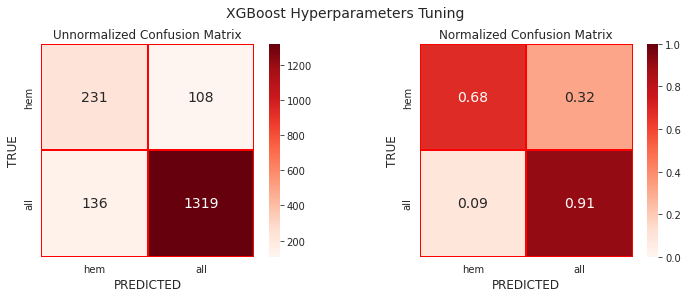

In [ ]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('XGBoost Hyperparameters Tuning', y_test, y_pred_opt, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred_opt, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.63      0.68      0.65       339
         all       0.92      0.91      0.92      1455

    accuracy                           0.86      1794
   macro avg       0.78      0.79      0.78      1794
weighted avg       0.87      0.86      0.87      1794



# Optuna GPU & CV10-mean #8

## Optuna Objective Function

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 10, 20), # changed
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 200, 700), # changed
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 8), # changed
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    # Fit the model
    model = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
    # model.fit(X_train, y_train)

    # # Make predictions
    # y_pred = model.predict(X_test)

    # # Evaluate predictions
    # ###  accuracy = accuracy_score(y_test, y_pred)
    # f1 = f1_score(y_test, y_pred)
    # return f1
    pruning_callback = XGBoostPruningCallback(trial, "validation_0-auc")
    fit_params = {'callbacks' : [pruning_callback],
                  #'eval_metric' : 'auc',
                  'eval_set' : [(X_test, y_test)]}

    score = cross_val_score(model, X_train, y_train, n_jobs=2, scoring='f1', cv=10, fit_params=fit_params).mean()
    return score

## Optuna Study

In [ ]:
sampler = TPESampler(seed=random_state)
study = optuna.create_study(direction='maximize', sampler=sampler)

[I 2023-04-16 00:06:29,208] A new study created in memory with name: no-name-f70bb880-fcc5-42f8-9acf-20eaf734b535


## Optimize the Objective Function

In [ ]:
study.optimize(objective, n_trials=100)

[I 2023-04-16 00:09:26,636] Trial 0 finished with value: 0.8246481138303947 and parameters: {'max_depth': 18, 'learning_rate': 0.011002817226254392, 'n_estimators': 517, 'min_child_weight': 6, 'gamma': 9.728728830009641e-05, 'subsample': 0.02815744802026465, 'colsample_bytree': 0.024895779540435023, 'reg_alpha': 0.012140755068184341, 'reg_lambda': 2.2536511574969237e-07}. Best is trial 0 with value: 0.8246481138303947.
[I 2023-04-16 00:15:39,740] Trial 1 finished with value: 0.8590749298558551 and parameters: {'max_depth': 10, 'learning_rate': 0.23481164807395874, 'n_estimators': 677, 'min_child_weight': 1, 'gamma': 0.00012518091079635779, 'subsample': 0.4219314744806921, 'colsample_bytree': 0.16790055575223653, 'reg_alpha': 0.005943503728075847, 'reg_lambda': 2.1627610787257848e-06}. Best is trial 1 with value: 0.8590749298558551.
[I 2023-04-16 00:20:04,242] Trial 2 finished with value: 0.8272433376941108 and parameters: {'max_depth': 20, 'learning_rate': 0.26862817821882146, 'n_estim

#### Colab runtime was disconnected after trial 72.

We will use the best score at that time: the score from trial 47.

## Best Parameters

In [ ]:
# Copied results from trial 47
parameters = {'max_depth': 15, 'learning_rate': 0.049567057287928484, 'n_estimators': 615, 'min_child_weight': 2, 'gamma': 0.0030569426894407037, 'subsample': 0.7815782090261838, 'colsample_bytree': 0.1662299223859651, 'reg_alpha': 8.179492960144827e-08, 'reg_lambda': 1.2272162692341417e-07}
parameters

{'max_depth': 15,
 'learning_rate': 0.049567057287928484,
 'n_estimators': 615,
 'min_child_weight': 2,
 'gamma': 0.0030569426894407037,
 'subsample': 0.7815782090261838,
 'colsample_bytree': 0.1662299223859651,
 'reg_alpha': 8.179492960144827e-08,
 'reg_lambda': 1.2272162692341417e-07}

In [ ]:
print(f'Number of finished trials: 72')
print('Best trial:')
best_trial_value = 0.8748118206555116

print(f'  Value: {best_trial_value}')
print('  Params: ')

for key, value in parameters.items():
    print(f'    {key}: {value}')

Number of finished trials: 72
Best trial:
  Value: 0.8748118206555116
  Params: 
    max_depth: 15
    learning_rate: 0.049567057287928484
    n_estimators: 615
    min_child_weight: 2
    gamma: 0.0030569426894407037
    subsample: 0.7815782090261838
    colsample_bytree: 0.1662299223859651
    reg_alpha: 8.179492960144827e-08
    reg_lambda: 1.2272162692341417e-07


## Re-fit the model

In [ ]:
params = parameters

clf_xgb_opt = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
clf_xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.1662299223859651, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.0030569426894407037, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.049567057287928484, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=615, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [ ]:
# Save the model
joblib.dump(clf_xgb_opt, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_8.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_8.save']

In [ ]:
y_pred_opt = clf_xgb_opt.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_opt)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 85.95


In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {clf_xgb_opt.score(X_train, y_train)}")
print(f"Testing Data Score: {clf_xgb_opt.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8595317725752508


In [ ]:
cm = confusion_matrix(y_test, y_pred_opt)
print(cm)

[[ 227  112]
 [ 140 1315]]


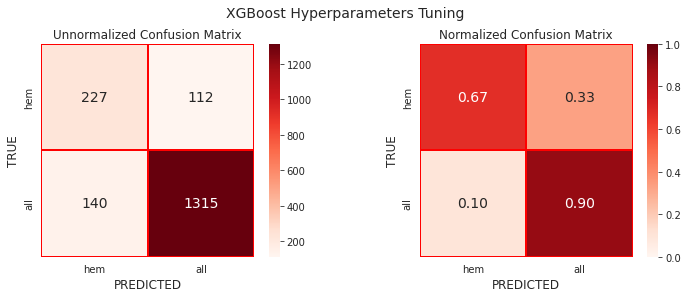

In [ ]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('XGBoost Hyperparameters Tuning', y_test, y_pred_opt, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred_opt, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.62      0.67      0.64       339
         all       0.92      0.90      0.91      1455

    accuracy                           0.86      1794
   macro avg       0.77      0.79      0.78      1794
weighted avg       0.86      0.86      0.86      1794



# Comparison

In [10]:
xgb = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_base.save')
y_pred_base = xgb.predict(X_test)
xgb_opt1 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_1.save')
y_pred1 = xgb_opt1.predict(X_test)
xgb_opt2 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_2.save')
y_pred2 = xgb_opt2.predict(X_test)
xgb_opt3 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_3.save')
y_pred3 = xgb_opt3.predict(X_test)
xgb_opt4 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_4.save')
y_pred4 = xgb_opt4.predict(X_test)
xgb_opt5 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_5.save')
y_pred5 = xgb_opt5.predict(X_test)
xgb_opt6 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_6.save')
y_pred6 = xgb_opt6.predict(X_test)
xgb_opt7 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_7.save')
y_pred7 = xgb_opt7.predict(X_test)
xgb_opt8 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_8.save')
y_pred8 = xgb_opt8.predict(X_test)


In [11]:
pred_d = {'XGBoost - Base' : y_pred_base,
          'XGBoost Optuna #1' : y_pred1,
          'XGBoost - Optuna #2' : y_pred2,
          'XGBoost - Optuna #3' : y_pred3,
          'XGBoost - Optuna #4' : y_pred4,
          'XGBoost - Optuna #5' : y_pred5,
          'XGBoost - Optuna CV3-mean #6' : y_pred6,
          'XGBoost - Optuna CV5-mean #7' : y_pred7,
          'XGBoost - Optuna CV10-mean #8' : y_pred8
}

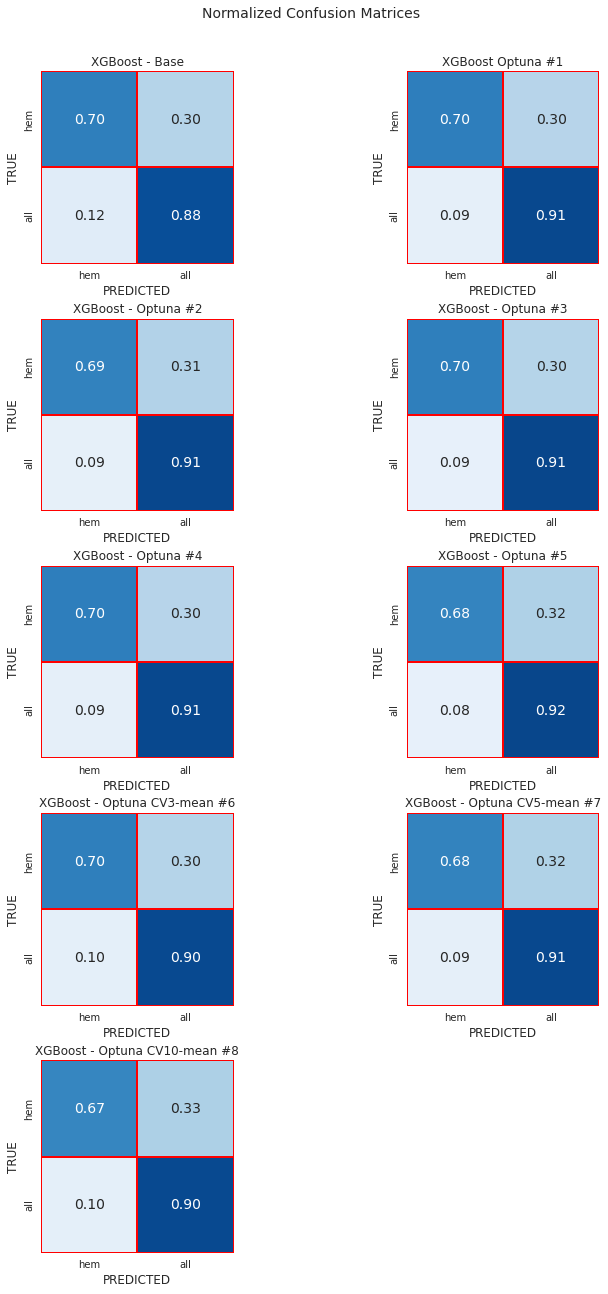

In [12]:
# Plot all confusion matrices - normalized
mu.plot_conf_matrices(pred_d, y_test, target_names, 'Blues')

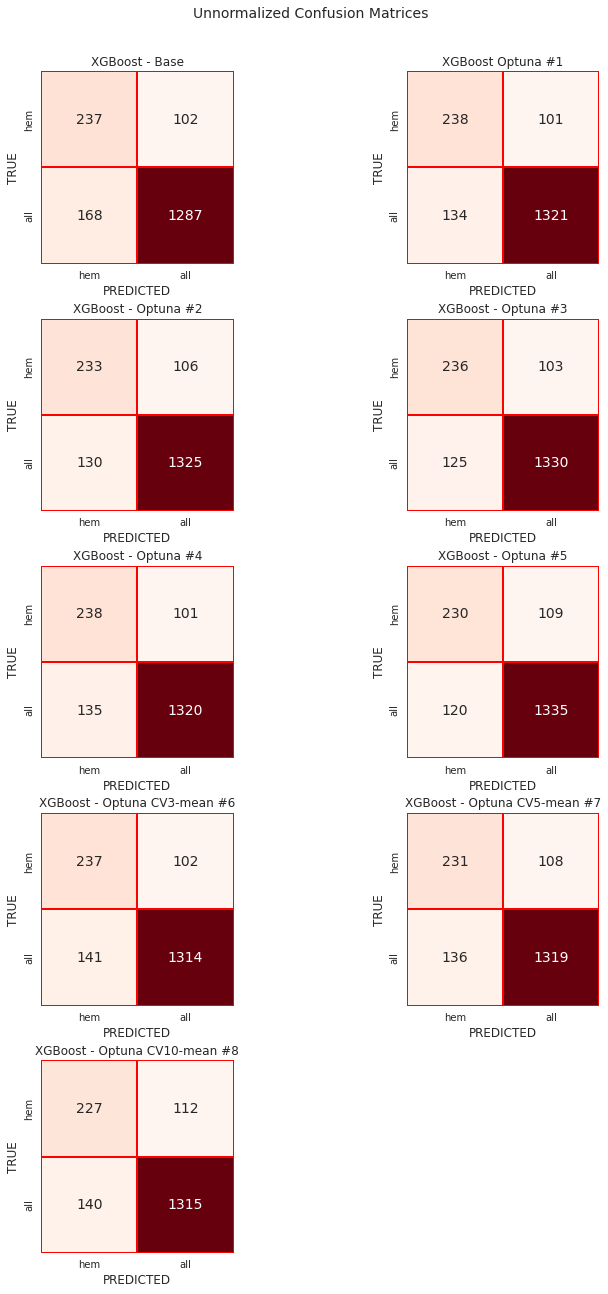

In [13]:
# Plot all confusion matrices - unnormalized
mu.plot_conf_matrices(pred_d, y_test, target_names, 'Reds', norm=False)

## Plot ROC Curves

In [14]:
# Load best performing models
xgb_opt1 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_1.save')
xgb_opt3 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_3.save')
xgb_opt5 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4/clf_xgb_opt_5.save')

In [15]:
# Best performing models dictionary
best_models = {'XGBoost - Optuna #1' : xgb_opt1,
          'XGBoost - Optuna #3' : xgb_opt3,
          'XGBoost - Optuna #5' : xgb_opt5
}

#### Create function to plot ROC curves for train and test data

In [16]:
def plot_roc_curves(model_name, model, batch, X_train, X_test, y_train, y_test):
    fig, [ax_train, ax_test] = plt.subplots(1, 2, figsize=(11, 5))
    fig.suptitle(f'{model_name}', fontsize=14)
    
    pred_train = model.predict(X_train)
    pred_test= model.predict(X_test)
    auc_train = roc_auc_score(y_train, pred_train)
    auc_test = roc_auc_score(y_test, pred_test)
    fpr_train, tpr_train, _ = roc_curve(y_train, pred_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, pred_test)

    ax_train.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
    ax_test.plot([0, 1], [0, 1], 'r--', label='Random Guessing')

    ax_train.plot(fpr_train, tpr_train, label=f'{model_name} (AUC: {auc_train:.2f})')
    ax_test.plot(fpr_test, tpr_test, label=f'{model_name} (AUC: {auc_test:.4f})')

    ax_train.set_title(f'ROC curve - Train Data - {batch}')
    ax_test.set_title(f'ROC curve - Test Data- {batch}')
                    
    ax_train.set_xlabel('False positive rate')
    ax_test.set_xlabel('False positive rate')

    ax_train.set_ylabel('True positive rate')
    ax_test.set_ylabel('True positive rate')

    ax_train.legend(loc='best')
    ax_test.legend(loc='best')

    plt.show()
    print()

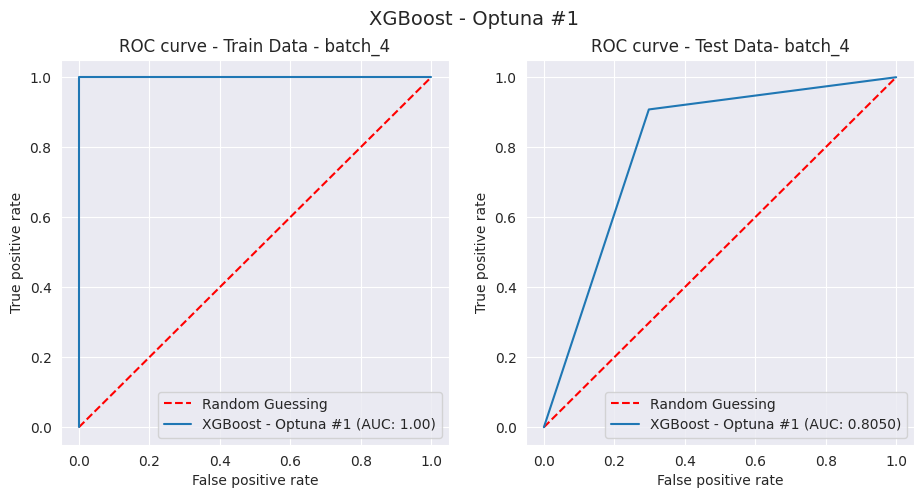

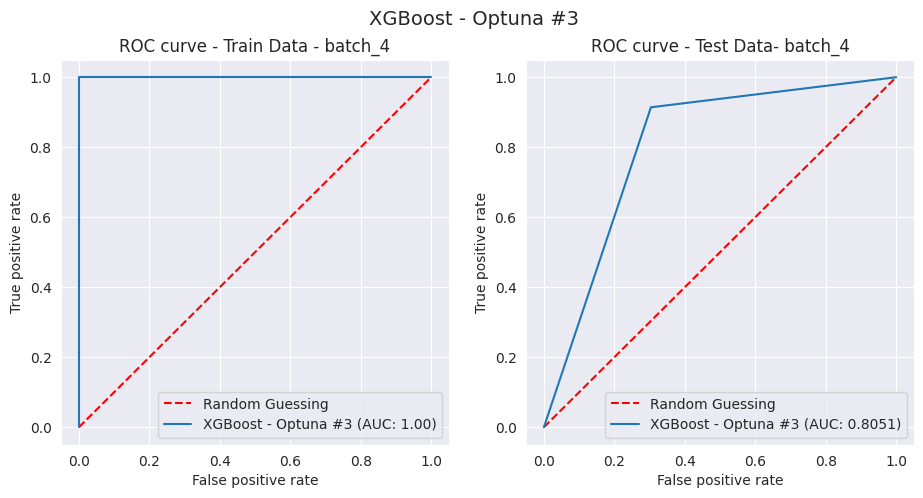

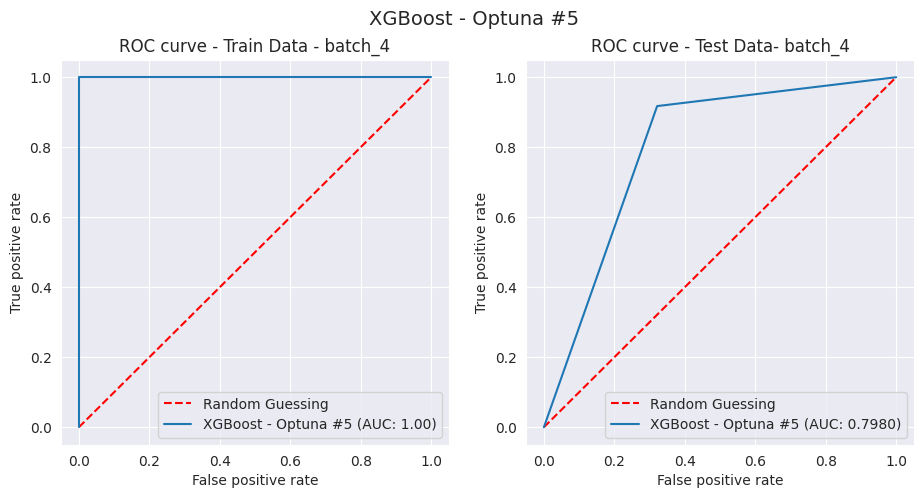

In [17]:
# Plot ROC curves for each of best performing models
for mn, m in best_models.items():
    plot_roc_curves(mn, m, 'batch_4', X_train, X_test, y_train, y_test)